# Assignment 10

In this assignment we'll examine a data set in `diabetes.csv`. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

## Data Description

This dataset is originally from 

    Reaven, G. M. and Miller, R. G. (1979). An attempt to define the nature of chemical diabetes using a multidimensional analysis. Diabetologia, 16, 17-24. 

The `group` column provides labels that the researches came up with. They should not be taken as fact or used in your finite mixture model (because they are discrete). Interestingly, the labels provided can be used to compare with the labels you might generate from your model.

In [3]:
diab = pd.read_csv("diabetes.csv")
diab.head()

relwt  glufast  glutest  instest  sspg   group
0   0.81       80      356      124    55  Normal
1   0.95       97      289      117    76  Normal
2   0.94      105      319      143   105  Normal
3   1.04       90      356      199   108  Normal
4   1.00       90      323      240   143  Normal

## Problem 1:

In general, if your data has $D$ columns, and you assume your model has $H$ clusters, how many parameters in total are there for

 - the general case of fully flexible covariance matrices,
 - assuming all groups have the same general covariance structure,
 - assuming variables are uncorrelated in all groups, and
 - assuming that in every group, all features have the same variance *and* are uncorrelated with one another?


# There are 3 general parameters: $\mu$, $\Sigma$, $\lambda$. 
Bullet 1
$\mu$: $H$ * $D$ means 
$\Sigma$: for a $D$ x $D$ covariance matrix is $\frac{D(D+1)}{2}$ for each group $H$  
$\lambda$: $H$ (1 $\lambda$ for each group)  
Total: $H$ * $D$ + $H$ * $\frac{D(D+1)}{2}$ + $H$)

Bullet 2
$\mu$: $H$ * $D$ means  
$\Sigma$: for a $D$ x $D$ covariance matrix is $\frac{D(D+1)}{2}$ This is the same for all variables.  
$\lambda$: $H$ (1 $\lambda$ for each group)  
Total: $H$ * $D$ + $\frac{D(D+1)}{2}$ + $H$ 

Bullet 3
$\mu$: $H$ * $D$ means  
$\Sigma$: $H$ * $D$ variances (all covariances are 0 since all variables are uncorrelated)  
$\lambda$: $H$ (1 $\lambda$ for each group)  
Total: $H$ * $D$ + $H$ * $D$ + $H$ (so 2 ($H$ * $D$) + $H$)

Bullet 4
$\mu$: $H$ * $D$ means  
$\Sigma$: $H$ (all variances are the same for each group and all covariances are 0 since all variables are uncorrelated)
$\lambda$: $H$ (1 $\lambda$ for each group)  
Total: $H$ * $D$ + $H$ + $H$ (so $H$ * $D$ + 2 * $H$)

## Problem 2: Inference on $\theta$ and $z$

Estimate the parameters of your finite mixture of normals model. Attach your (heavily) modified `.stan` file to your submission so that we may run it when graded your work.

Please be sure to address the following questions about $\theta$ inference:

1. Are you sure your posterior for $\theta$ is identifiable?
2. What did you spend most of your time doing to get this to be so?
3. Discuss the *meaning* of your group categories that you found (i.e. which group is the "healthy" group, etc. etc.)

Please report all the usual stuff, too.

Regarding the $z$ inference:

4. Should you pay attention to $\hat{R}$ diagnostics for `label_prob` variables?
5. Which individual is one of the most difficult to categorize? Why do you think this is interesting to identify?
6. What percentage of the time do your individual person labels correspond to the labels given to you in the `.csv` file?

Finally:

7. Are there any interesting scientific questions that are not addressed by this finite mixture model?

### Hints

**Expect to do a lot of experimentation with**
 - which columns to transform or remove so that everything is conditionally normal, 
 - how many clusters to assume you have, and most of all
 - **how to properly describe your prior beliefs**.

The biggest difficult you will have is trying to specify priors to make the posterior identifiable--to know which cluster group is which. **Remember what we said about $\hat{R}$s in lecture!** Dealing with this also helps with the speed of the algorithm.

More hints: 

 1. Use scatterplots (pairwise or 3-d) to help you visualize how many clusters there need to be. Use Occam's razor!
 2. Feel free to "cheat" in order to come up with priors that identify your posterior. 
 3. While you're figuring everything out, it might be faster to prototype to temporarily restrict your attention to a random subset of the data. 

## Answer
This comes with a story of my anguish before you get to the meat of assignment. This assignment was a mess. I have 4 stan file written for this homeowrk. The first one is Dr. Browns. I had no idea where to start so I just ran it on the data as is (he advised us to do this once just to see it). After that I didn't know where to go. So to Chatgpt I went (he told us we could). Chat had 2 basic suggestions for getting the $\hat{R}$s down: switch the inverse wishart to an lkj and split up the mean to prevent label switching. So I did both those things, together and separate. So the other 3 stan file are a switch to the lkj, the parsed out mu, and both. So any time I ran something, I ran it on all 4 to see what would happen. First I ran the data no edits, then I transformed all the variables and ran that. I tried many transformations: logging, square rooting, standardizing, using a boxcox. Then I tried removing different varaibles (or combos of variables). Each time running each variation on all 4 stan files. To make it easier on myself I created a code block of dropping different variables and then just reran the models with the new 'data' wihtout having to change any other code (to see all this work you can open the 'assingment10-Copy1,ipynb' file. Warning, it's a bit of a mess. But it follows a similar structure to what is here). Since this was my tactic I created a spreadsheet of what I ran, the $\hat{R}$s of each model, and the number of clusters it generated. If it had anything other than 3 clusters, I ignored it. If it had 3 clusters (to match the 3 in the csv file) I ran the accuracy to see how well it did. You can see this in the file 'Compiling_data.xlsx'. On there, there are 3 times where the model accuracy was above 80%. They are highlighted in green. My plan (which as you will see I carry out) was to put all 3 on the document and discuss them because the model with the highest accuracy had a graph that looked pretty bad (basically it achieved its accuracy by oversampling the majority class, so it doesn't look like it did a very good job of actually identifying). However, as I brought the 3 models over all achieved differently than it did previous. The best model now used 4 clusters instead of 3 (I know there may be a use case for a different number of clusters, but for the sake of this assignment I am holding to the original 3 for a comparison). The second best models accuracy dropped by over 10%, and the third models actually jumped to be as accurate as the most accurate from earlier. So I run the rest of the analysis on that one. But there in lies the biggest frustration: every time I reran a model I got different results. Usually wildly different (which you can see if you compare the first thing in model in this documnet to its accompanying one in the copy document). It was so hard to work when I couldn't rely on anything staying consistent. Basically if I got a model that seemed like it was a good fit for this assignment I had to leave it because if it got lost it's lost forever and good luck getting anything similar even with the same setup. I got some models that even had $\hat{R}$s at essentially 1, but if I reran them at least one would be in the double digits (those models never worked anyway because they never gave 3 clusters but still). So this homework drove me bonkers. I hope that you can see how much effort I put into this and didn't just try and phone it in.  
  
Okay rant over. Thank you for listening. Here's what I came u with and the story it tells (hopefully a better one than the one above)

I knew I needed to run the data without the group column so here's me dropping it another dataframe.

In [4]:
dia = diab.drop('group', axis=1)

My first task was to see the data. I did some data visualiztions to see it.

Text(0.5, 1.0, 'sspg')

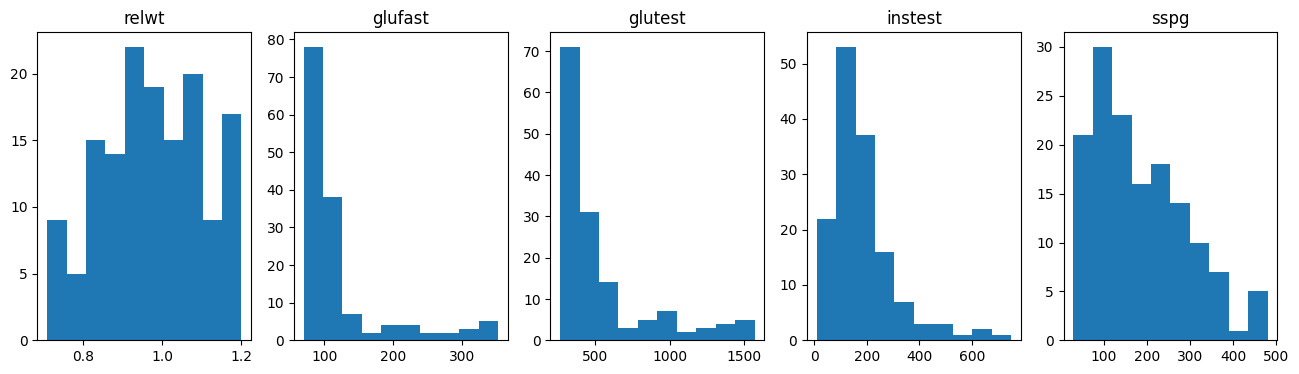

In [5]:
fig1, (a1, b1, c1, d1, e1) = plt.subplots(1, 5, figsize=(16,4))

a1.hist(diab['relwt'])
a1.set_title('relwt')

b1.hist(diab['glufast'])
b1.set_title('glufast')

c1.hist(diab['glutest'])
c1.set_title('glutest')

d1.hist(diab['instest'])
d1.set_title('instest')

e1.hist(diab['sspg'])
e1.set_title('sspg')

/tmp/ipykernel_10383/1998434297.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_categories))


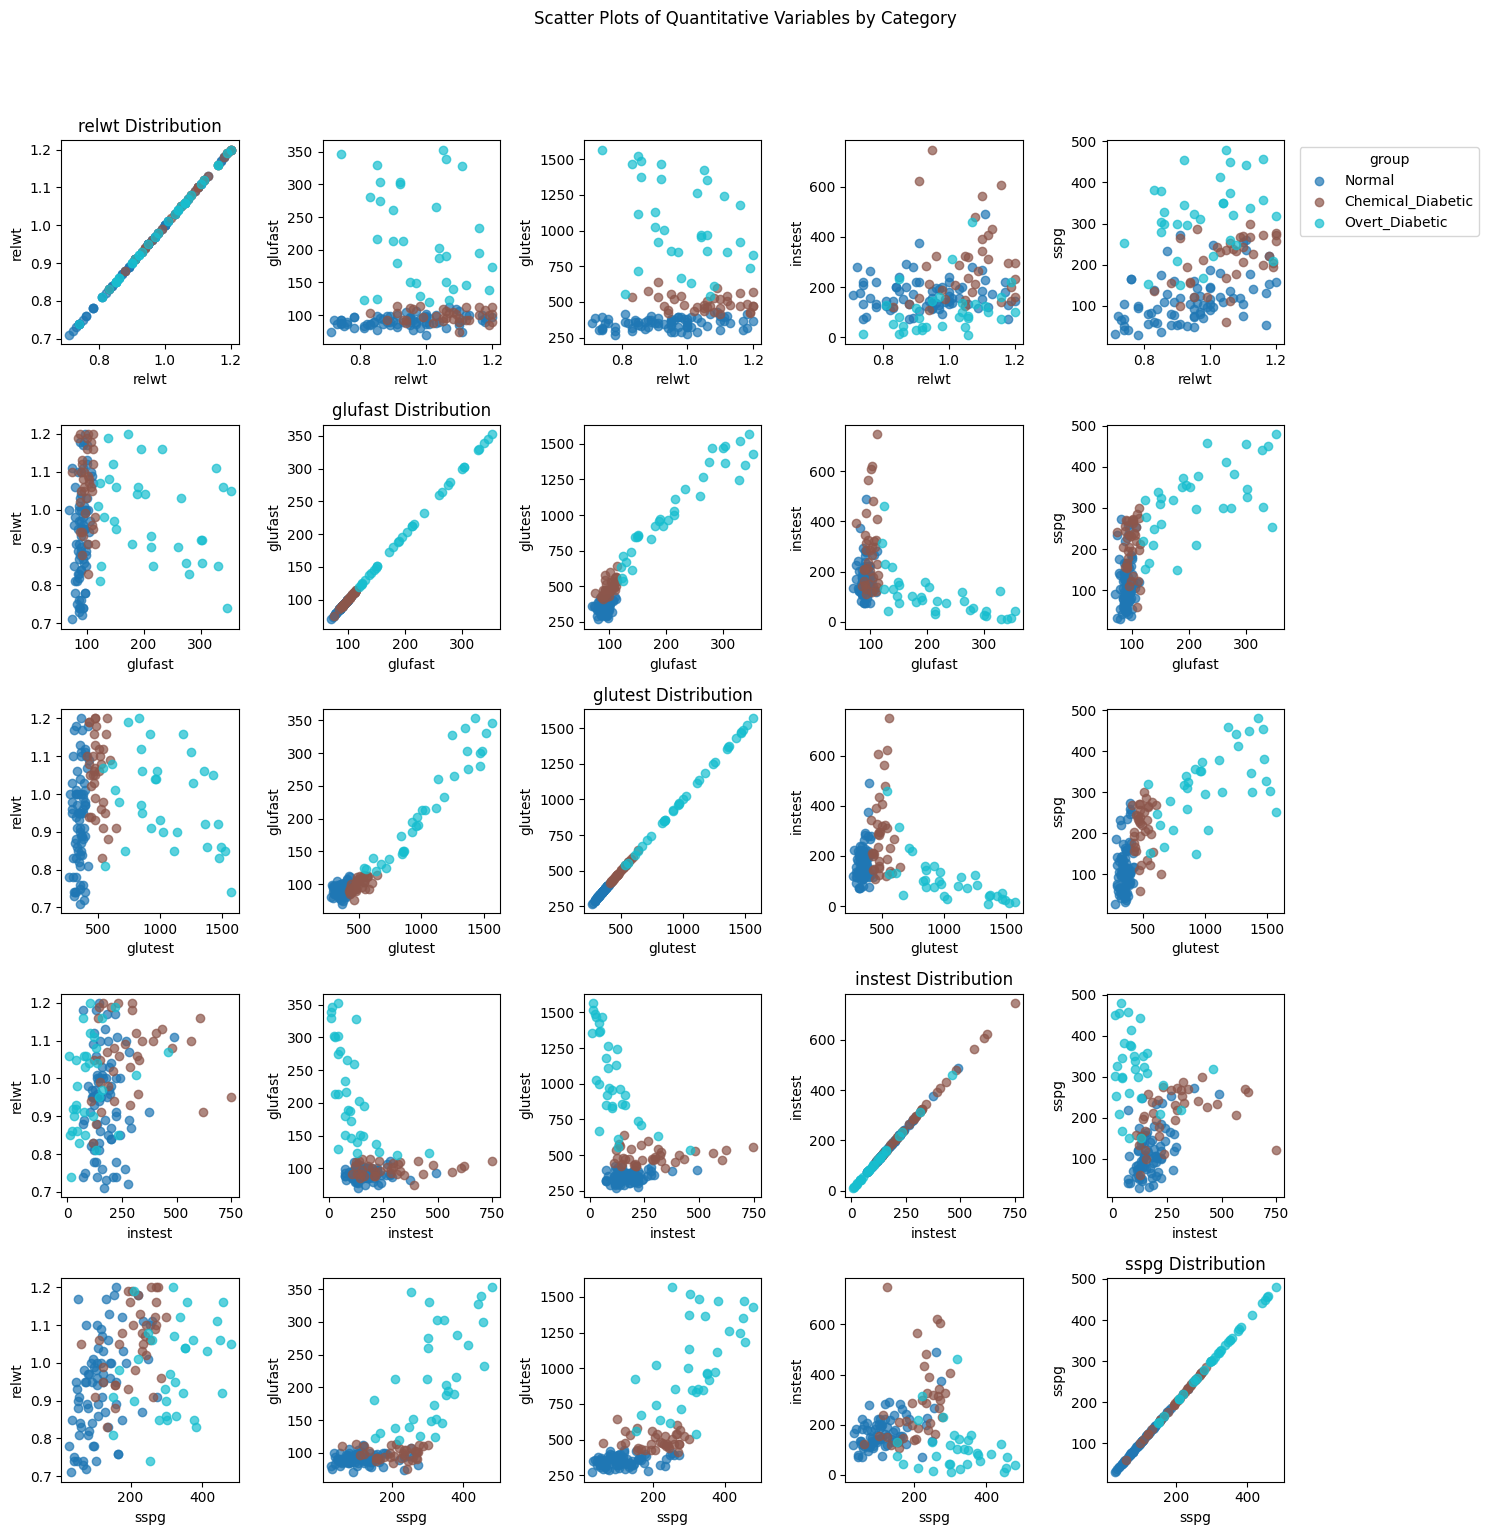

In [8]:
quantitative_vars = ['relwt', 'glufast', 'glutest', 'instest', 'sspg']
categorical_var = 'group'

unique_categories = diab[categorical_var].unique()
colors = plt.cm.get_cmap('tab10', len(unique_categories))
category_to_color = {category: colors(i) for i, category in enumerate(unique_categories)}

num_vars = len(quantitative_vars)
fig, axes = plt.subplots(num_vars, num_vars, figsize=(15, 15))
fig.suptitle('Scatter Plots of Quantitative Variables by Category', y=1.02)


for i, var_x in enumerate(quantitative_vars):
    for j, var_y in enumerate(quantitative_vars):
        ax = axes[i, j]

        for category in unique_categories:
            subset = diab[diab[categorical_var] == category]
            ax.scatter(subset[var_x], subset[var_y], 
                       color=category_to_color[category], 
                       label=category, alpha=0.7)

        ax.set_xlabel(var_x)
        ax.set_ylabel(var_y)
        if i == j:
            ax.set_title(f'{var_x} Distribution')

        if i == 0 and j == num_vars - 1:
            ax.legend(title=categorical_var, bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [9]:
dia.corr()

relwt   glufast   glutest   instest      sspg
relwt    1.000000 -0.008813  0.023984  0.222238  0.384320
glufast -0.008813  1.000000  0.964628 -0.396235  0.715480
glutest  0.023984  0.964628  1.000000 -0.337020  0.770942
instest  0.222238 -0.396235 -0.337020  1.000000  0.007914
sspg     0.384320  0.715480  0.770942  0.007914  1.000000

Some of the data needed to be transformed. I used a log transformation because most of the variables were skewed.

In [6]:
log_diab = diab.copy()
log_diab['relwet'] = np.log(diab['relwt'])
log_diab['glufast'] = np.log(diab['glufast'])
log_diab['glutest'] = np.log(diab['glutest'])
log_diab['instest'] = np.log(diab['instest'])
log_diab['sspg'] = np.log(diab['sspg'])

Text(0.5, 1.0, 'log sspg')

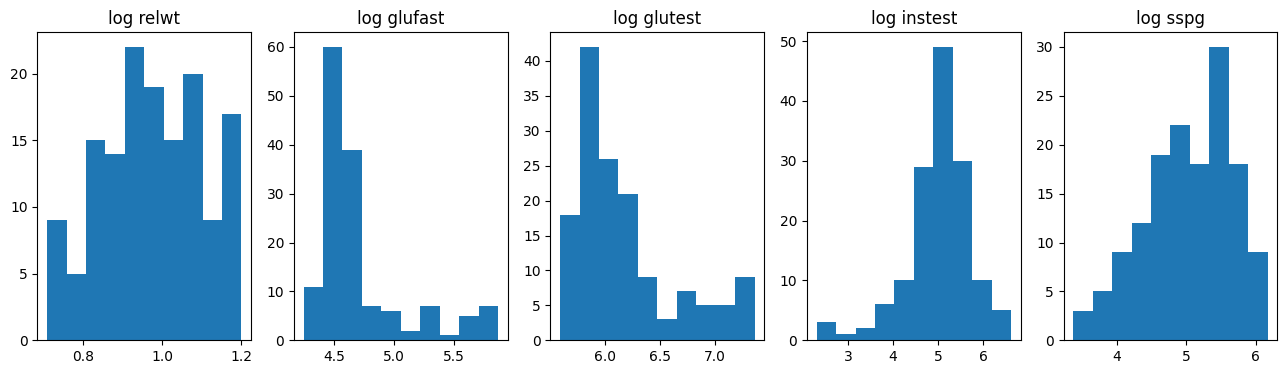

In [7]:
fig2, (a2, b2, c2, d2, e2) = plt.subplots(1, 5, figsize=(16,4))

a2.hist(log_diab['relwt'])
a2.set_title('log relwt')

b2.hist(log_diab['glufast'])
b2.set_title('log glufast')

c2.hist(log_diab['glutest'])
c2.set_title('log glutest')

d2.hist(log_diab['instest'])
d2.set_title('log instest')

e2.hist(log_diab['sspg'])
e2.set_title('log sspg')

In my workings of this homework I had trouble figuring out the priors. I know little about diabetes so I didn't want know where to center the normal curves. Someone had the idea to standardize everything so that it was all centered around 0 and I can therefore use 0 as the mean of any normal distribution. Here is that code.  
  
(At the time of this writing I'm now realizing that before this I used a prior of normal(0,2) and now that I've standardized this that 2 should probably be a 1. I wonder what that would do to the models. At this time though (Sunday night hours before it's due) I neither have the time nor the energy to find out. See rant above for reason...)

In [10]:
trans_diab = diab.copy()
trans_diab['relwt'] = ((dia['relwt'] - diab['relwt'].mean())/ diab['relwt'].std())
trans_diab['glufast'] = np.log(diab['glufast'])
trans_diab['glufast'] = ((diab['glufast'] - diab['glufast'].mean())/ diab['glufast'].std())
trans_diab['glutest'] = np.log(diab['glutest'])
trans_diab['glutest'] = ((diab['glutest'] - diab['glutest'].mean())/ diab['glutest'].std())
trans_diab['instest'] = np.log(diab['instest'])
trans_diab['instest'] = ((diab['instest'] - diab['instest'].mean())/ diab['instest'].std())
trans_diab['sspg'] = np.log(diab['sspg'])
trans_diab['sspg'] = ((diab['sspg'] - diab['sspg'].mean())/ diab['sspg'].std())

In [11]:
trans_dia = trans_diab.copy()
trans_dia = trans_dia.drop('group', axis=1)

/tmp/ipykernel_10383/3114044616.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_categories))


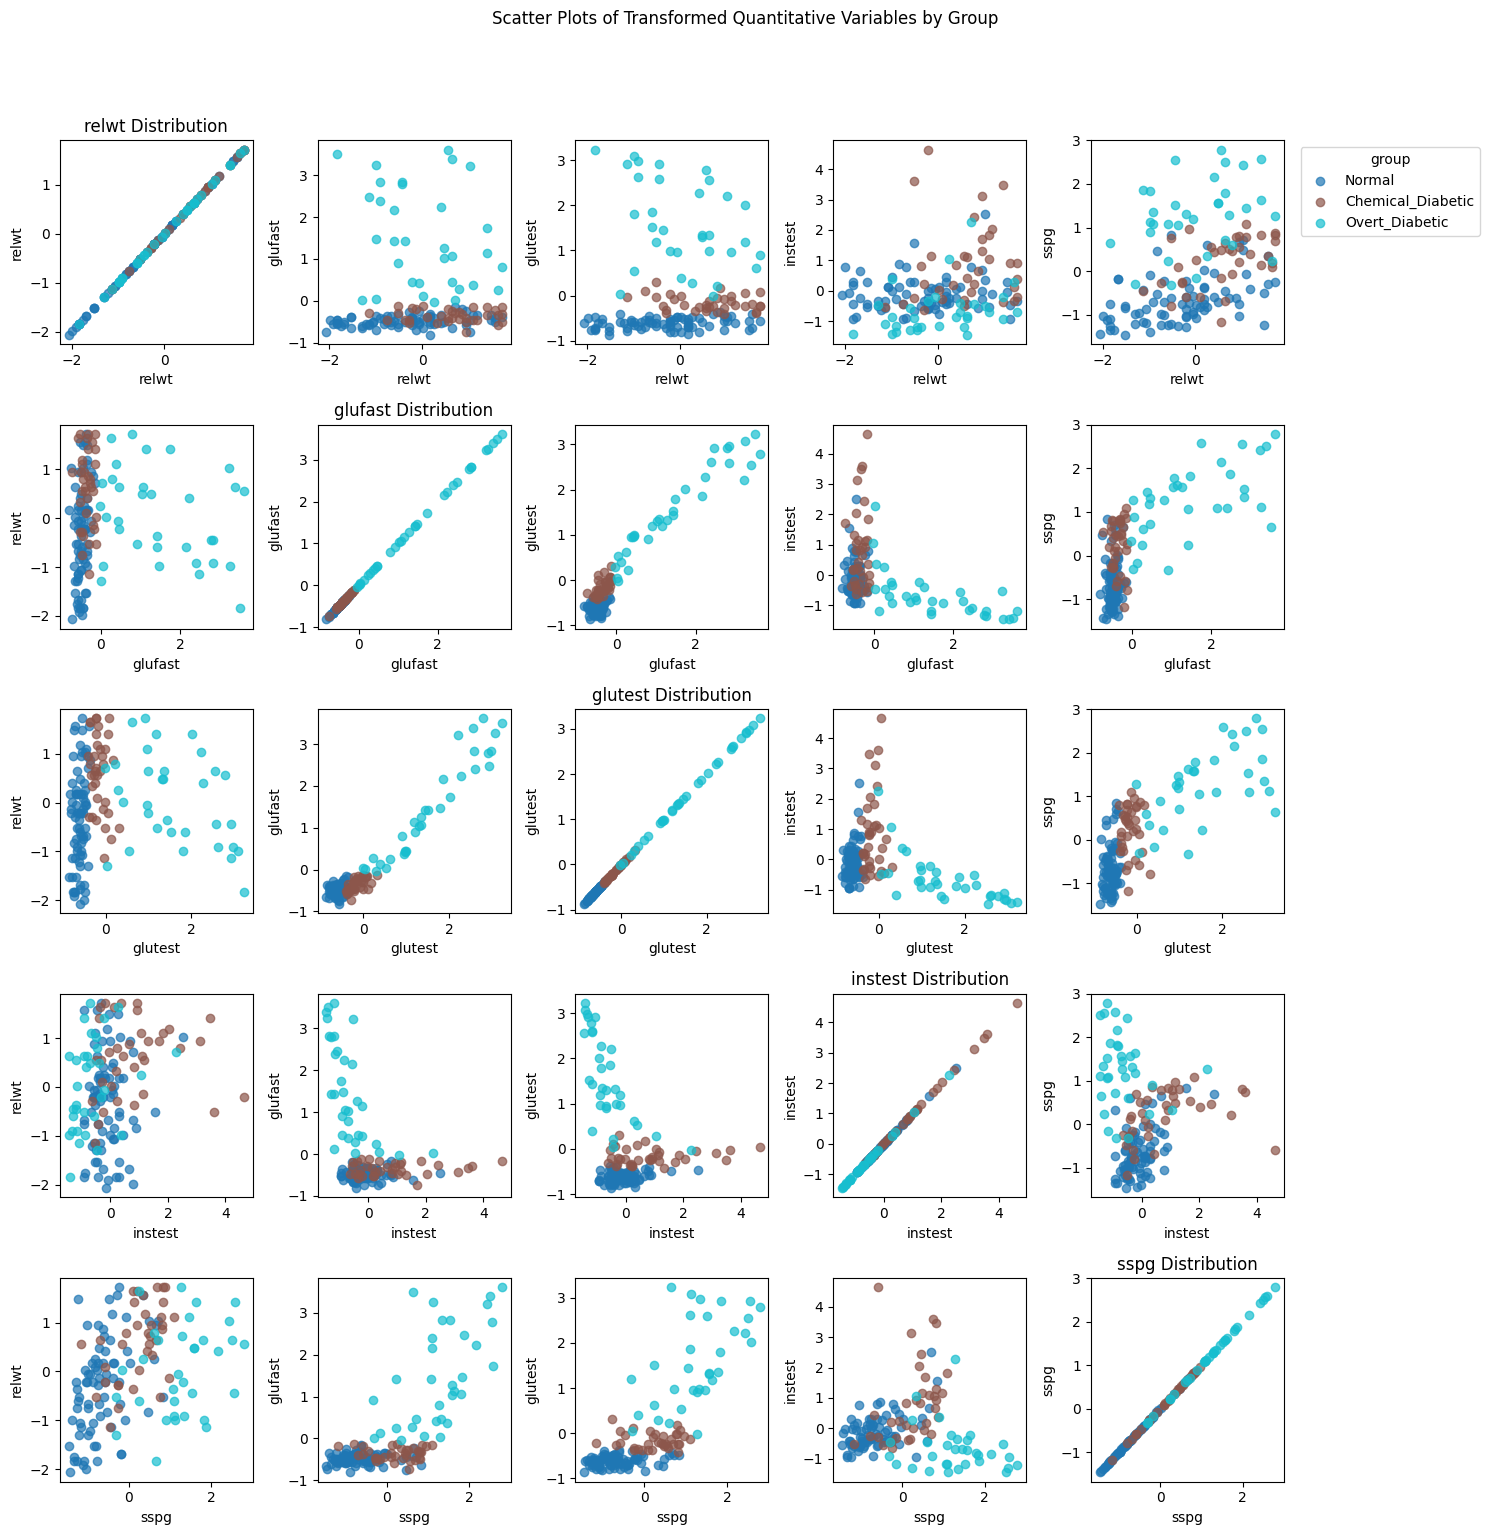

In [12]:
quantitative_vars = ['relwt', 'glufast', 'glutest', 'instest', 'sspg']
categorical_var = 'group'

unique_categories = trans_diab[categorical_var].unique()
colors = plt.cm.get_cmap('tab10', len(unique_categories))
category_to_color = {category: colors(i) for i, category in enumerate(unique_categories)}

num_vars = len(quantitative_vars)
fig, axes = plt.subplots(num_vars, num_vars, figsize=(15, 15))
fig.suptitle('Scatter Plots of Transformed Quantitative Variables by Group', y=1.02)


for i, var_x in enumerate(quantitative_vars):
    for j, var_y in enumerate(quantitative_vars):
        ax = axes[i, j]

        for category in unique_categories:
            subset = trans_diab[trans_diab[categorical_var] == category]
            ax.scatter(subset[var_x], subset[var_y], 
                       color=category_to_color[category], 
                       label=category, alpha=0.7)

        ax.set_xlabel(var_x)
        ax.set_ylabel(var_y)
        if i == j:
            ax.set_title(f'{var_x} Distribution')

        if i == 0 and j == num_vars - 1:
            ax.legend(title=categorical_var, bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [13]:
trans_dia.corr()

relwt   glufast   glutest   instest      sspg
relwt    1.000000 -0.008813  0.023984  0.222238  0.384320
glufast -0.008813  1.000000  0.964628 -0.396235  0.715480
glutest  0.023984  0.964628  1.000000 -0.337020  0.770942
instest  0.222238 -0.396235 -0.337020  1.000000  0.007914
sspg     0.384320  0.715480  0.770942  0.007914  1.000000

Knowing my plan was to take you down a preperscribed path, I did some preediting here. I will explain each model as I get to them.

In [15]:
transr_diab = trans_diab.copy()
transr_diab = transr_diab.drop('relwt', axis=1)
transr_dia = transr_diab.copy()
transr_dia = transr_dia.drop('group', axis=1)

In [16]:
transg_diab = trans_diab.copy()
transg_diab = transg_diab.drop('relwt', axis=1)
transg_dia = transg_diab.copy()
transg_dia = transg_dia.drop('group', axis=1)

In [18]:
t_data = {'N' : trans_dia.shape[0], 'D': trans_dia.shape[1],  'y': trans_dia}
r_data = {'N' : transr_dia.shape[0], 'D': transr_dia.shape[1],  'y': transr_dia}
g_data = {'N' : transg_dia.shape[0], 'D': transg_dia.shape[1],  'y': transg_dia}

Now for running the models! As mentioned my plan is to run the 3 models that achieved the best accuracy and figure which one is the best to use. The general flow for each model is the same: I run the model, I print the summary to see the $\hat{R}$s of the lambdas, I plot the lambdas to see the fuzzy caterpillars, I graph the original data coded by color side by side with the posterior coded by color to inspect visually, then I check the accuracy of the model.  
  
The first model was run with the lkj stan file from the transformed with 'relwt' removed. While 'relwt' didn't seem to cause any problem in the EDA, it also did not help distinguish any insights.

In [19]:
modelf_code = os.path.join('.', 'finite_mixture_normals.stan')
modelf = CmdStanModel(stan_file=modelf_code)

In [20]:
modell_code = os.path.join('.', 'lkj.stan')
modell = CmdStanModel(stan_file=modell_code)

In [27]:
fitlr = modell.sample(data = r_data)

23:59:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:59:22 - cmdstanpy - INFO - CmdStan done processing.
23:59:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[4] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[4] is 0, but must be positive! (in 'lkj.stan', line 28, column 4 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj.st

In [28]:
fitlr.summary().iloc[0:4]

Mean      MCSE    StdDev          5%         50%         95%  \
lp__      -319.232000  0.126114  4.905110 -327.763000 -318.761000 -311.811000   
lambda[1]    0.400528  0.100682  0.149353    0.199528    0.395456    0.605394   
lambda[2]    0.386045  0.113679  0.166166    0.162566    0.402813    0.608272   
lambda[3]    0.213427  0.022564  0.048893    0.145722    0.206792    0.306150   

                N_Eff    N_Eff/s    R_hat  
lp__       1512.76000  50.994900  1.00280  
lambda[1]     2.20049   0.074178  3.18728  
lambda[2]     2.13660   0.072024  3.80886  
lambda[3]     4.69504   0.158269  1.30677

Text(0.5, 1.0, 'lambda 3')

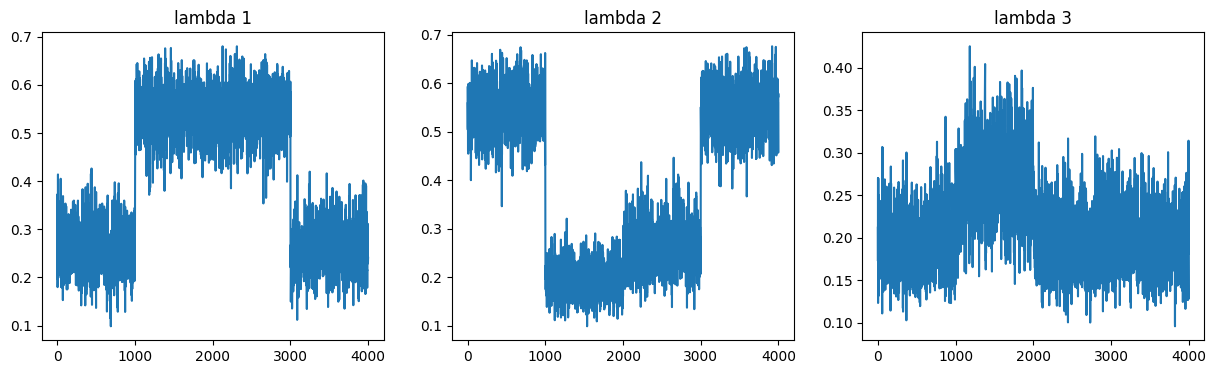

In [29]:
figlr, (lra, lrb, lrc) = plt.subplots(1, 3, figsize=(15,4))

lra.plot(fitlr.draws_pd()['lambda[1]'])
lra.set_title('lambda 1')

lrb.plot(fitlr.draws_pd()['lambda[2]'])
lrb.set_title('lambda 2')

lrc.plot(fitlr.draws_pd()['lambda[3]'])
lrc.set_title('lambda 3')

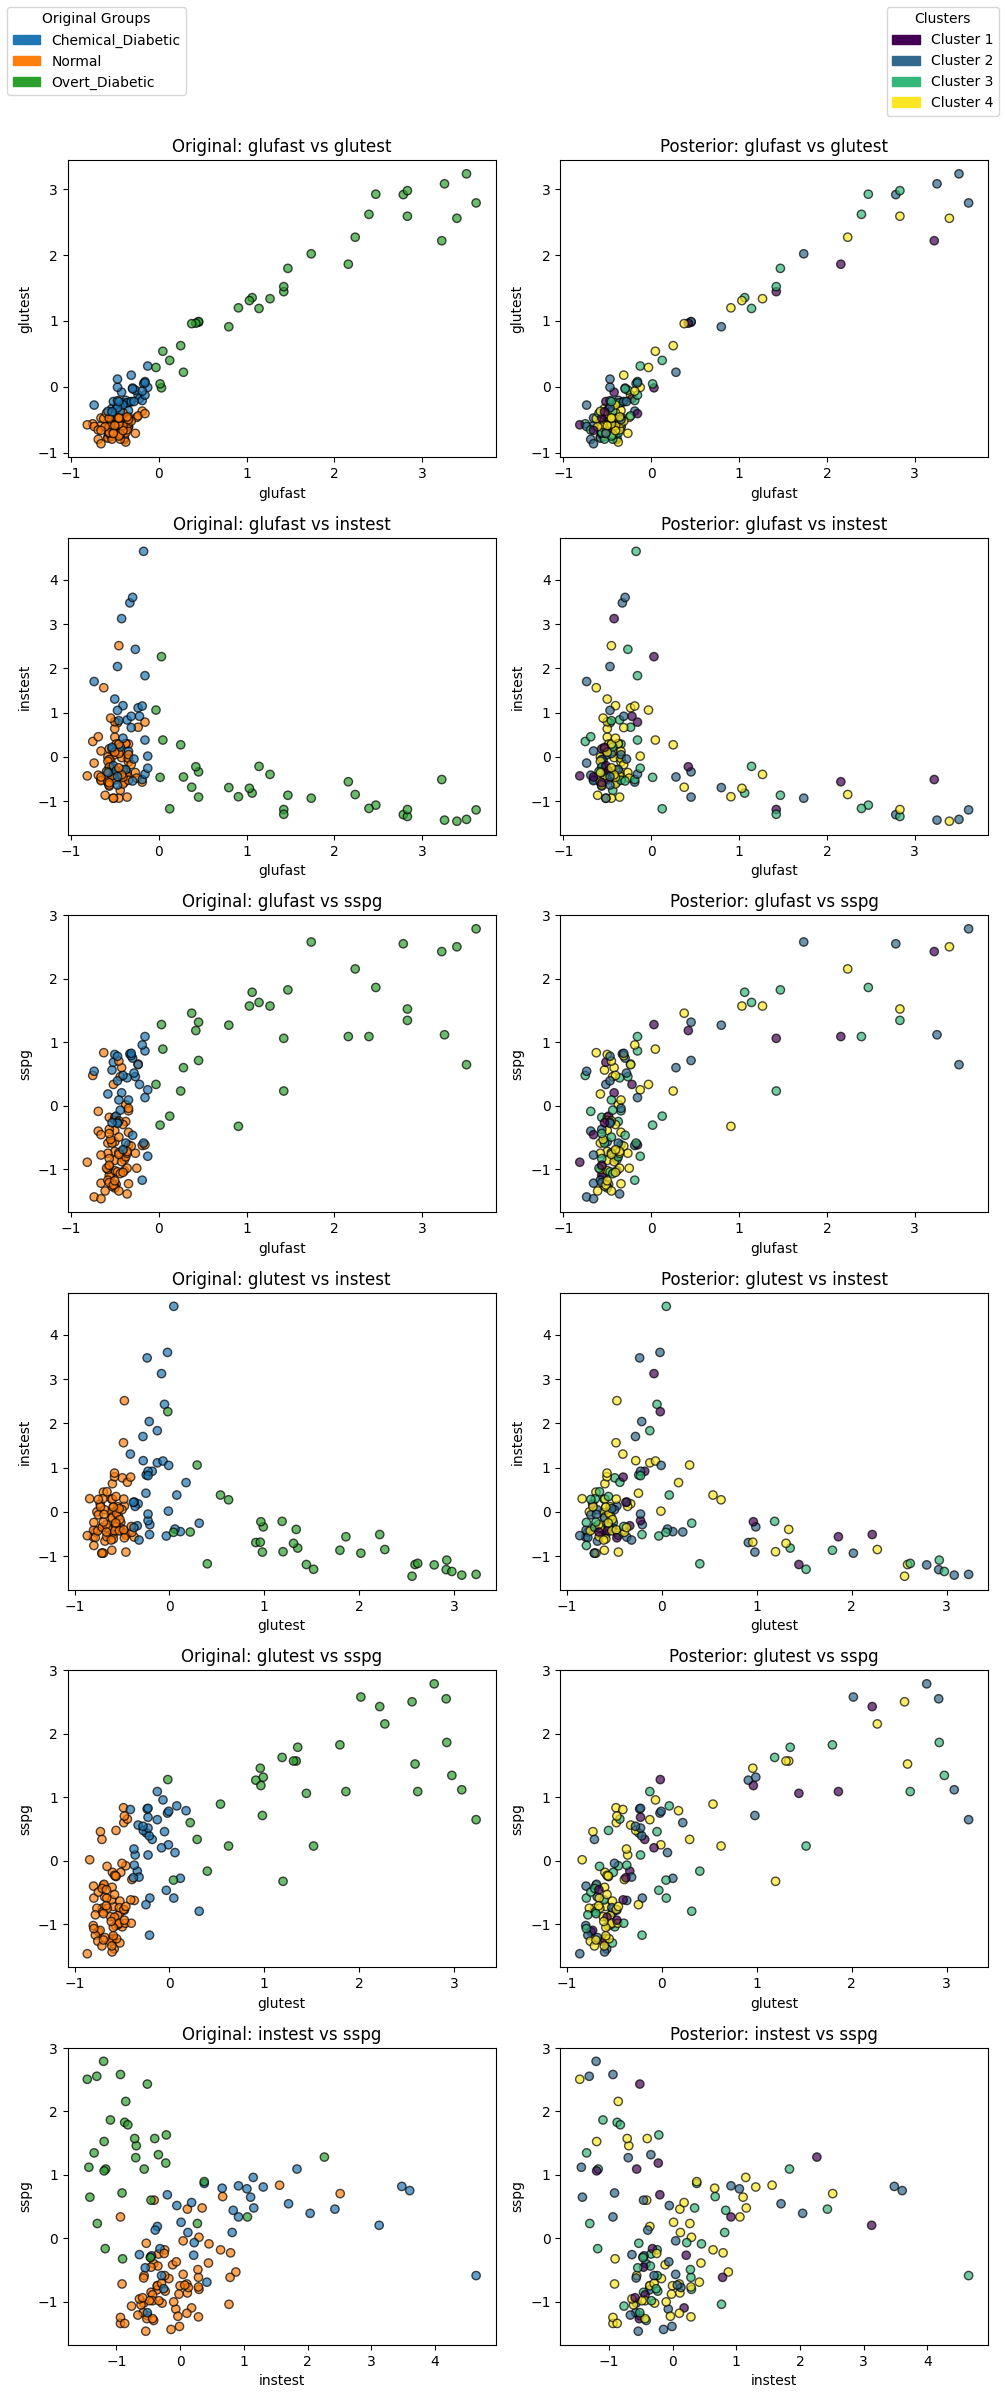

In [30]:
label_problr = fitlr.stan_variable('label_prob')
label_problr_mean = np.mean(label_problr, axis=0)
cluster_assignmentlr = np.argmax(label_problr_mean, axis=1)

feature_names = list(transr_dia) 
num_features = len(feature_names)

pairs = list(itertools.combinations(range(num_features), 2))
n_pairs = len(pairs)
 
original_labels = transr_diab['group'].values
numeric_labels = pd.Categorical(original_labels).codes
original_cat = pd.Categorical(original_labels)
categories = original_cat.categories
codes = original_cat.codes
 
# Create colormap and get colors for each category code
cmap = plt.get_cmap('tab10')
colors = cmap(np.arange(len(categories)))
 
 
fig, axes = plt.subplots(nrows=n_pairs, ncols=2, figsize=(10, 4*n_pairs))
 
for idx, (i, j) in enumerate(pairs):
    ax_left = axes[idx, 0] if n_pairs > 1 else axes[0]
    ax_right = axes[idx, 1] if n_pairs > 1 else axes[1]
    
    # Left: use mapped colors by manually assigning colors based on code
    point_colors = [colors[code] for code in codes]
    ax_left.scatter(
        transr_diab.iloc[:, i], transr_diab.iloc[:, j],
        c=point_colors, edgecolors='k', alpha=0.7
    )
    ax_left.set_xlabel(feature_names[i])
    ax_left.set_ylabel(feature_names[j])
    ax_left.set_title(f'Original: {feature_names[i]} vs {feature_names[j]}')
 
    # Right: cluster plot as before
    ax_right.scatter(
        transr_diab.iloc[:, i], transr_diab.iloc[:, j],
        c=cluster_assignmentlr, cmap='viridis', edgecolors='k', alpha=0.7
    )
    ax_right.set_xlabel(feature_names[i])
    ax_right.set_ylabel(feature_names[j])
    ax_right.set_title(f'Posterior: {feature_names[i]} vs {feature_names[j]}')
 
# Legend for original groups
orig_patches = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
fig.legend(handles=orig_patches, loc='upper left', title='Original Groups')
 
# Legend for clusters remains the same as before
unique_clusters = np.unique(cluster_assignmentlr)
cluster_cmap = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
cluster_patches = [mpatches.Patch(color=cluster_cmap[i], label=f'Cluster {unique_clusters[i]+1}') for i in range(len(unique_clusters))]
fig.legend(handles=cluster_patches, loc='upper right', title='Clusters')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
mapping = {
    'Normal': 1,
    'Chemical_Diabetic': 0,
    'Overt_Diabetic': 2
}
diab_labels = np.array([mapping[g] for g in diab['group'].values])
 
matchlr = (cluster_assignmentlr == diab_labels)
accuracy = matchlr.mean() * 100
 
print("Number of matches:", matchlr.sum(), "out of", len(matchlr))
print(f"Accuracy: {accuracy:.2f}%")

Number of matches: 32 out of 145
Accuracy: 22.07%


Dispite its poor performance here, when I ran it earlier it had 3 clusters with an 84.83% accuracy. As mentioned before, I felt it oversampled the mojority class hence why I didn't just run with it. That point feels moot now since it didn't perform here. NEXT!

The next model was run on Dr. Brown's original stan file with the transformed data with no variables removed.

In [32]:
fitft = modelf.sample(data = t_data)

00:02:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:03:50 - cmdstanpy - INFO - CmdStan done processing.
00:03:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is -nan. (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] =

In [33]:
fitft.summary().iloc[0:4]

Mean      MCSE    StdDev          5%         50%         95%  \
lp__      -460.541000  0.286676  7.236750 -473.404000 -459.772000 -449.749000   
lambda[1]    0.313403  0.117947  0.172124    0.158432    0.234482    0.648844   
lambda[2]    0.392330  0.149229  0.217668    0.105053    0.386598    0.679081   
lambda[3]    0.294267  0.126534  0.185290    0.108132    0.215239    0.654504   

               N_Eff   N_Eff/s    R_hat  
lp__       637.24000  7.384010  1.00589  
lambda[1]    2.12967  0.024678  3.97030  
lambda[2]    2.12755  0.024653  3.98902  
lambda[3]    2.14433  0.024847  3.75933

Text(0.5, 1.0, 'lambda 3')

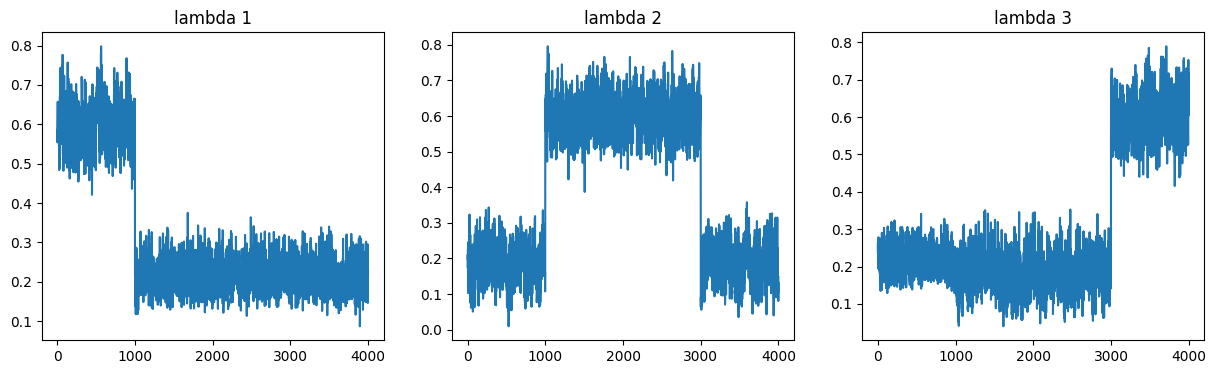

In [34]:
figft, (fta, ftb, ftc) = plt.subplots(1, 3, figsize=(15,4))

fta.plot(fitft.draws_pd()['lambda[1]'])
fta.set_title('lambda 1')

ftb.plot(fitft.draws_pd()['lambda[2]'])
ftb.set_title('lambda 2')

ftc.plot(fitft.draws_pd()['lambda[3]'])
ftc.set_title('lambda 3')

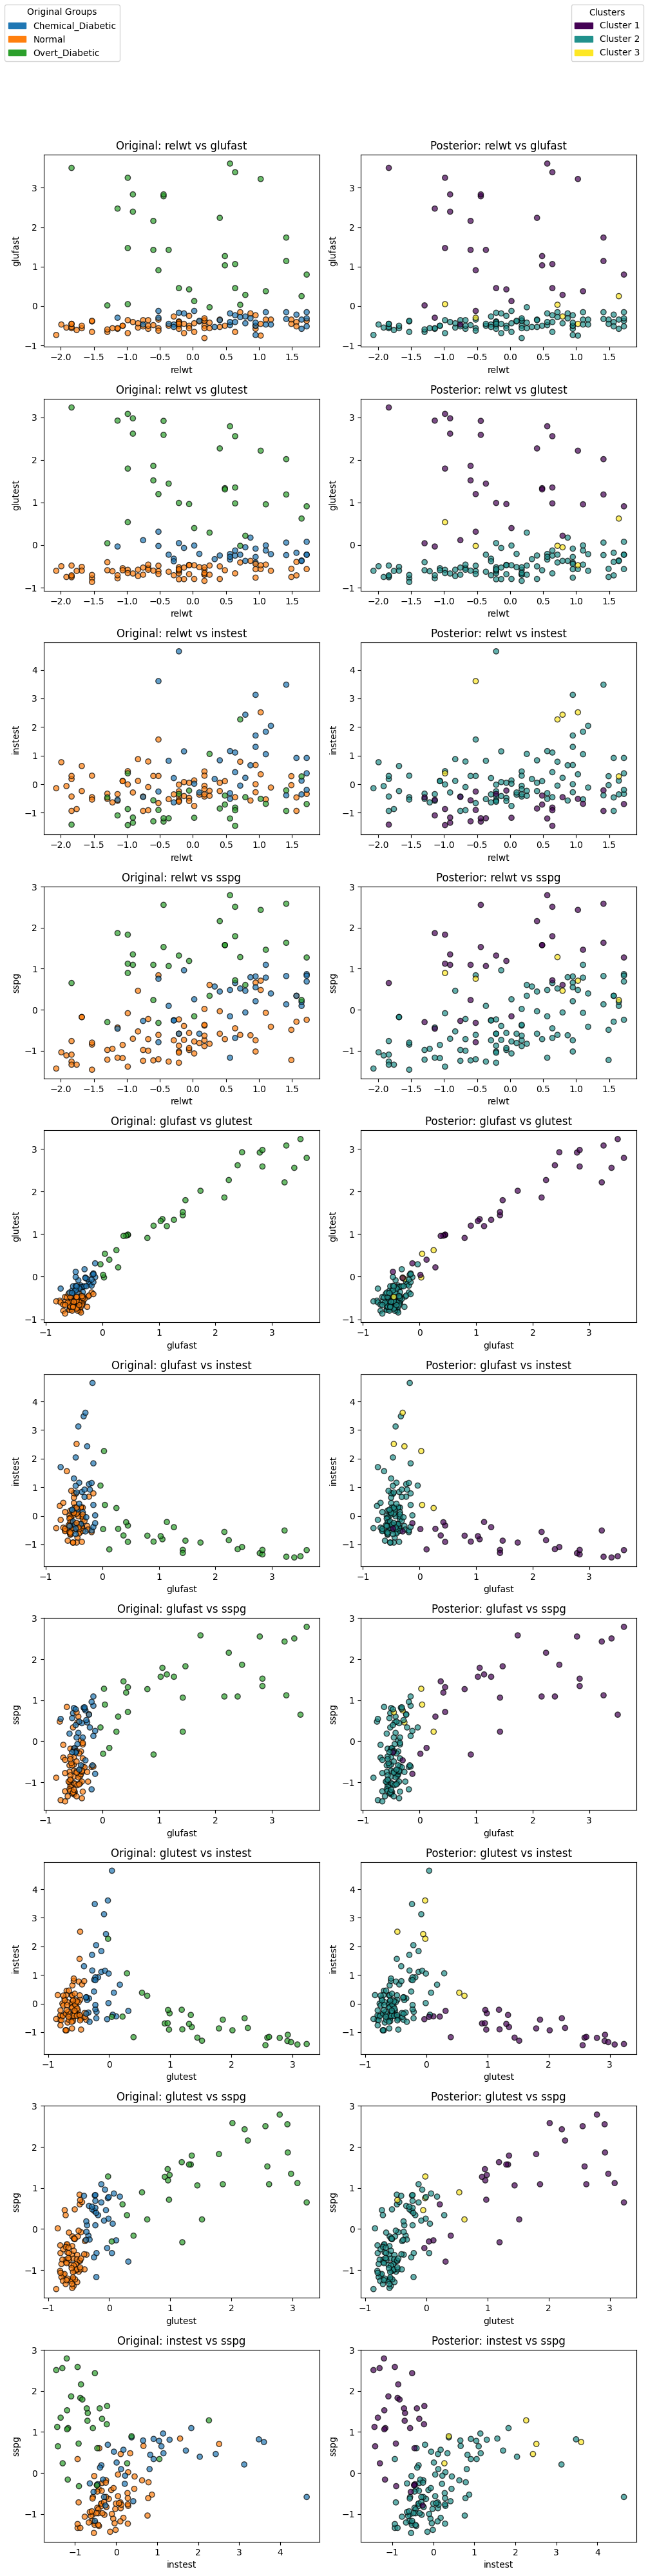

In [37]:
label_probft = fitft.stan_variable('label_prob')
label_probft_mean = np.mean(label_probft, axis=0)
cluster_assignmentft = np.argmax(label_probft_mean, axis=1)

feature_names = list(trans_dia) 
num_features = len(feature_names)

pairs = list(itertools.combinations(range(num_features), 2))
n_pairs = len(pairs)
 
original_labels = trans_diab['group'].values
numeric_labels = pd.Categorical(original_labels).codes
original_cat = pd.Categorical(original_labels)
categories = original_cat.categories
codes = original_cat.codes
 
# Create colormap and get colors for each category code
cmap = plt.get_cmap('tab10')
colors = cmap(np.arange(len(categories)))
 
 
fig, axes = plt.subplots(nrows=n_pairs, ncols=2, figsize=(10, 4*n_pairs))
 
for idx, (i, j) in enumerate(pairs):
    ax_left = axes[idx, 0] if n_pairs > 1 else axes[0]
    ax_right = axes[idx, 1] if n_pairs > 1 else axes[1]
    
    # Left: use mapped colors by manually assigning colors based on code
    point_colors = [colors[code] for code in codes]
    ax_left.scatter(
        trans_dia.iloc[:, i], trans_dia.iloc[:, j],
        c=point_colors, edgecolors='k', alpha=0.7
    )
    ax_left.set_xlabel(feature_names[i])
    ax_left.set_ylabel(feature_names[j])
    ax_left.set_title(f'Original: {feature_names[i]} vs {feature_names[j]}')
 
    # Right: cluster plot as before
    ax_right.scatter(
        trans_dia.iloc[:, i], trans_dia.iloc[:, j],
        c=cluster_assignmentft, cmap='viridis', edgecolors='k', alpha=0.7
    )
    ax_right.set_xlabel(feature_names[i])
    ax_right.set_ylabel(feature_names[j])
    ax_right.set_title(f'Posterior: {feature_names[i]} vs {feature_names[j]}')
 
# Legend for original groups
orig_patches = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
fig.legend(handles=orig_patches, loc='upper left', title='Original Groups')
 
# Legend for clusters remains the same as before
unique_clusters = np.unique(cluster_assignmentft)
cluster_cmap = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
cluster_patches = [mpatches.Patch(color=cluster_cmap[i], label=f'Cluster {unique_clusters[i]+1}') for i in range(len(unique_clusters))]
fig.legend(handles=cluster_patches, loc='upper right', title='Clusters')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [39]:
mapping = {
    'Normal': 1,
    'Chemical_Diabetic': 3,
    'Overt_Diabetic': 0
}
diab_labels = np.array([mapping[g] for g in diab['group'].values])
 
matchft = (cluster_assignmentft == diab_labels)
accuracy = matchft.mean() * 100
 
print("Number of matches:", matchft.sum(), "out of", len(matchft))
print(f"Accuracy: {accuracy:.2f}%")

Number of matches: 104 out of 145
Accuracy: 71.72%


It did...not bad. all $\hat{R}$s were less than 4 (that's a win copmpared what I was getting sometimes) and the caterpillars were fuzzy despite some jumps. The accuracy here is 71.72% which is way less than the 84.14% it was when I did it earlier. Let's see if we can do better.

The next model was run off of Dr. Brown's original with the transformed data with 'glutest'. 'glutest' or 'glufast' were my original candidates to remove simply because the correlation between them was so high. This could cause some colinearity problems.

In [40]:
fitfg = modelf.sample(data = g_data)

00:09:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:09:43 - cmdstanpy - INFO - CmdStan done processing.
00:09:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is -8.30269e-44. (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'finite_mixture_normals.stan', line 21, column 4 to column 65)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random var

In [42]:
fitfg.summary().iloc[0:4]

Mean      MCSE    StdDev          5%         50%         95%  \
lp__      -314.892000  0.216617  5.687610 -325.033000 -314.429000 -306.230000   
lambda[1]    0.300545  0.122880  0.181944    0.111499    0.226574    0.650005   
lambda[2]    0.497418  0.120947  0.178263    0.170625    0.569325    0.684658   
lambda[3]    0.202037  0.001714  0.044253    0.130833    0.202074    0.273446   

               N_Eff    N_Eff/s    R_hat  
lp__       689.40700  14.261900  1.00309  
lambda[1]    2.19237   0.045354  3.28133  
lambda[2]    2.17237   0.044940  3.44096  
lambda[3]  666.48400  13.787700  1.00348

Text(0.5, 1.0, 'lambda 3')

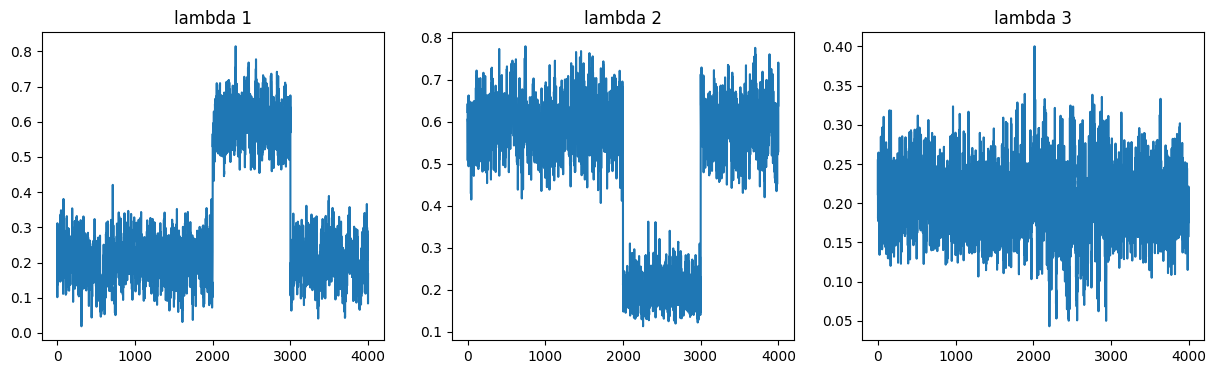

In [44]:
figfg, (fga, fgb, fgc) = plt.subplots(1, 3, figsize=(15,4))

fga.plot(fitfg.draws_pd()['lambda[1]'])
fga.set_title('lambda 1')

fgb.plot(fitfg.draws_pd()['lambda[2]'])
fgb.set_title('lambda 2')

fgc.plot(fitfg.draws_pd()['lambda[3]'])
fgc.set_title('lambda 3')

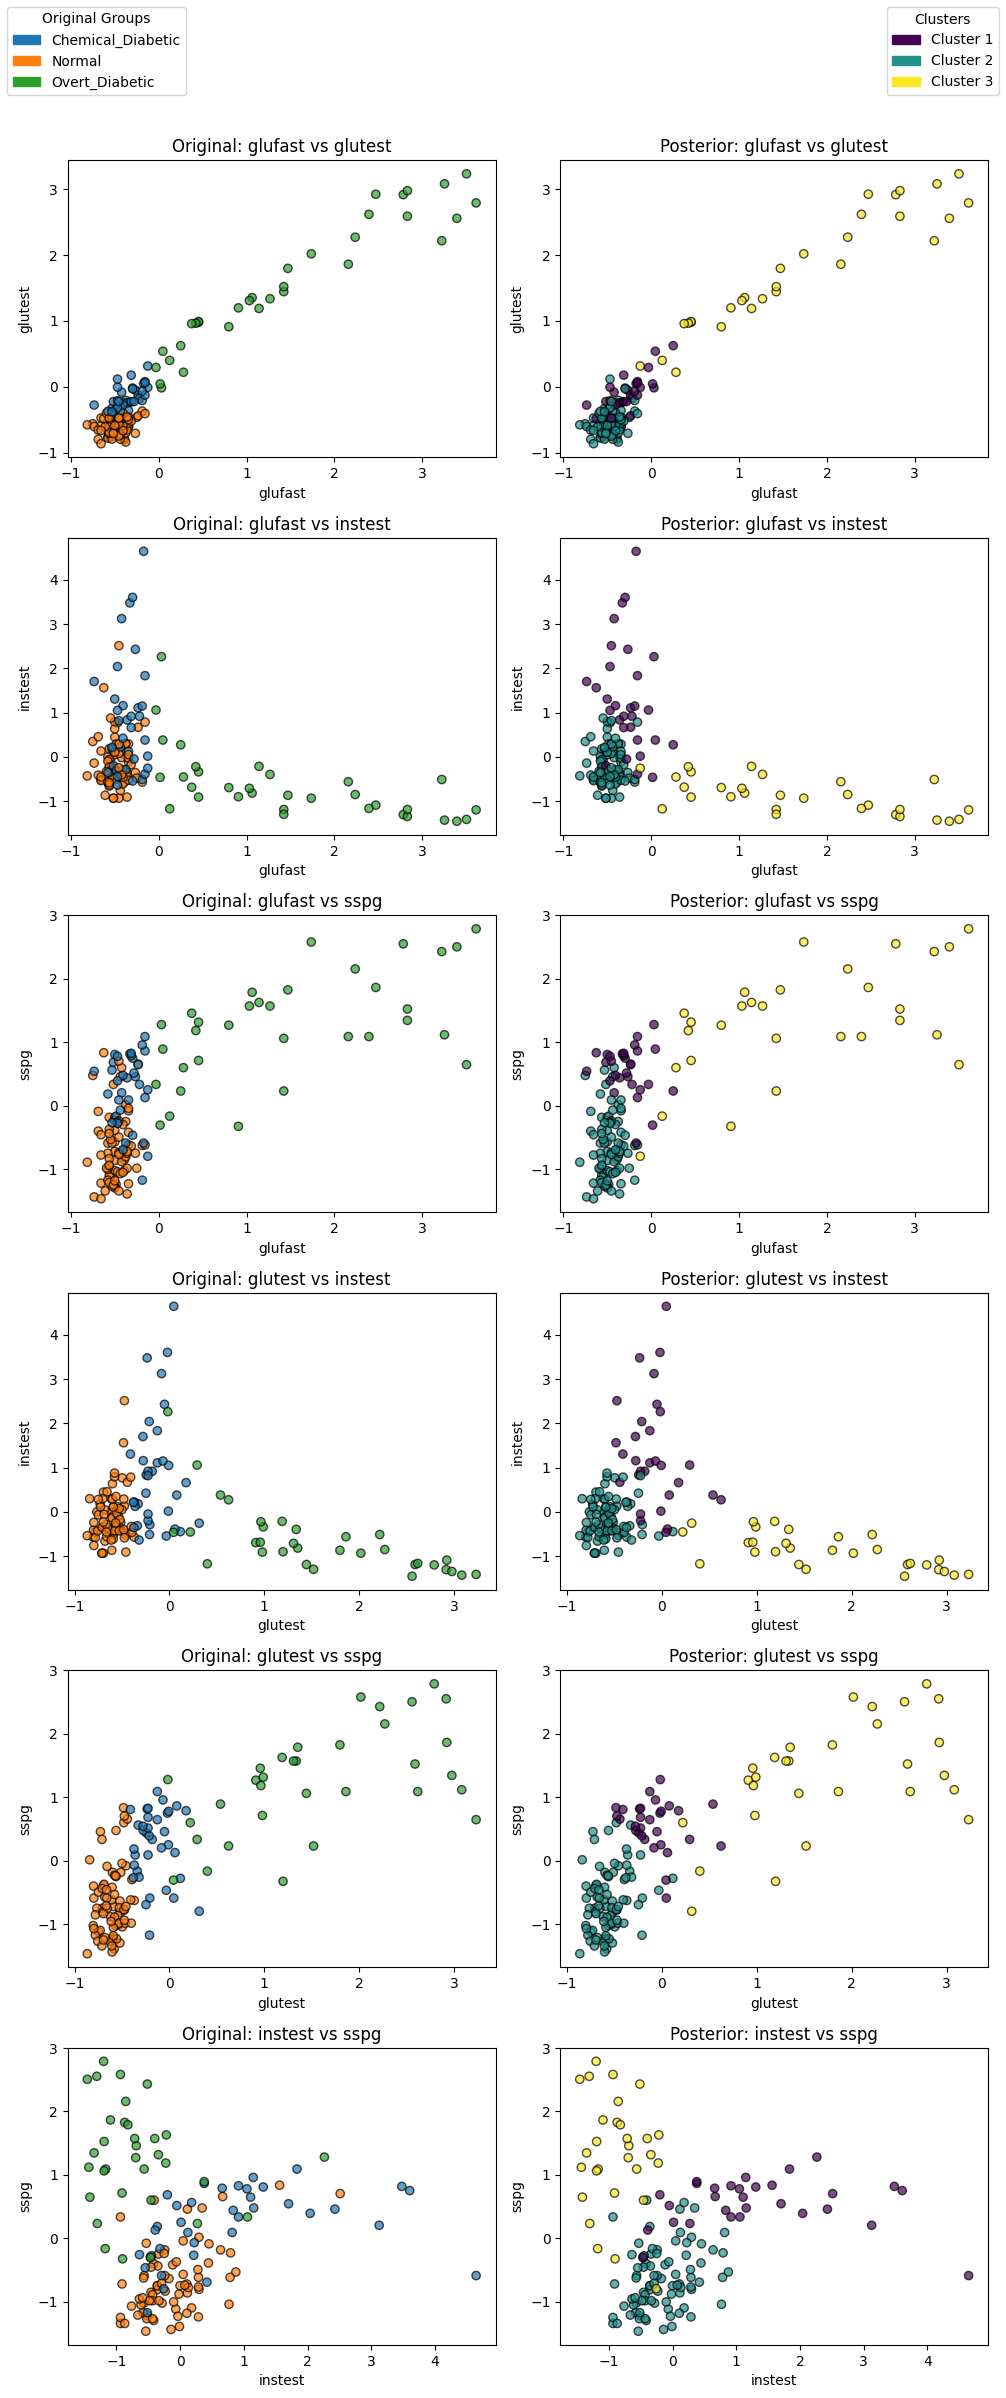

In [45]:
label_probfg = fitfg.stan_variable('label_prob')
label_probfg_mean = np.mean(label_probfg, axis=0)
cluster_assignmentfg = np.argmax(label_probfg_mean, axis=1)

feature_names = list(transg_dia) 
num_features = len(feature_names)

pairs = list(itertools.combinations(range(num_features), 2))
n_pairs = len(pairs)
 
original_labels = transg_diab['group'].values
numeric_labels = pd.Categorical(original_labels).codes
original_cat = pd.Categorical(original_labels)
categories = original_cat.categories
codes = original_cat.codes
 
# Create colormap and get colors for each category code
cmap = plt.get_cmap('tab10')
colors = cmap(np.arange(len(categories)))
 
 
fig, axes = plt.subplots(nrows=n_pairs, ncols=2, figsize=(10, 4*n_pairs))
 
for idx, (i, j) in enumerate(pairs):
    ax_left = axes[idx, 0] if n_pairs > 1 else axes[0]
    ax_right = axes[idx, 1] if n_pairs > 1 else axes[1]
    
    # Left: use mapped colors by manually assigning colors based on code
    point_colors = [colors[code] for code in codes]
    ax_left.scatter(
        transg_dia.iloc[:, i], transg_dia.iloc[:, j],
        c=point_colors, edgecolors='k', alpha=0.7
    )
    ax_left.set_xlabel(feature_names[i])
    ax_left.set_ylabel(feature_names[j])
    ax_left.set_title(f'Original: {feature_names[i]} vs {feature_names[j]}')
 
    # Right: cluster plot as before
    ax_right.scatter(
        transg_dia.iloc[:, i], transg_dia.iloc[:, j],
        c=cluster_assignmentfg, cmap='viridis', edgecolors='k', alpha=0.7
    )
    ax_right.set_xlabel(feature_names[i])
    ax_right.set_ylabel(feature_names[j])
    ax_right.set_title(f'Posterior: {feature_names[i]} vs {feature_names[j]}')
 
# Legend for original groups
orig_patches = [mpatches.Patch(color=colors[i], label=categories[i]) for i in range(len(categories))]
fig.legend(handles=orig_patches, loc='upper left', title='Original Groups')
 
# Legend for clusters remains the same as before
unique_clusters = np.unique(cluster_assignmentfg)
cluster_cmap = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
cluster_patches = [mpatches.Patch(color=cluster_cmap[i], label=f'Cluster {unique_clusters[i]+1}') for i in range(len(unique_clusters))]
fig.legend(handles=cluster_patches, loc='upper right', title='Clusters')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [47]:
mapping = {
    'Normal': 1,
    'Chemical_Diabetic': 0,
    'Overt_Diabetic': 2
}
diab_labels = np.array([mapping[g] for g in diab['group'].values])
 
matchfg = (cluster_assignmentfg == diab_labels)
accuracy = matchfg.mean() * 100
 
print("Number of matches:", matchfg.sum(), "out of", len(matchfg))
print(f"Accuracy: {accuracy:.2f}%")

Number of matches: 123 out of 145
Accuracy: 84.83%


CHA CHING! The $\hat{R}$ values better than the last (there's even one that ideal!) and the caterpillars look fuzzy despite a jump (one is perfect!). The accuracy here is 84.83%. (it was 82.07% previously, but this matches the highest accuracy I got on any model...winning). Cluster 3 from the posterior is clear overt_diabetic. Cluster 1 is the hardest to identify because it lies in overlaps both all 3 groups. However, since it seemed more reasonable that cluster 2 was normal, we get it just by process of elimination.
I know in the setup Dr. Brown said we would have to heavily modify his stan file. Here, I just transform the data and remove a variable and it works great. Beside, I really did try to write different stan files. And as mentioned earlier, this one initally came in first place. Whether this is a fluke or legit, don't know. But I'm running with it!

The next thing was to visualize the $\mu$s.

In [48]:
posterior_df = fitfg.draws_pd()
mu_samples = posterior_df.filter(like="mu")
mu_samples.columns

Index(['mu[1,1]', 'mu[2,1]', 'mu[3,1]', 'mu[1,2]', 'mu[2,2]', 'mu[3,2]',
       'mu[1,3]', 'mu[2,3]', 'mu[3,3]', 'mu[1,4]', 'mu[2,4]', 'mu[3,4]'],
      dtype='object')

Text(0.5, 1.0, 'mu[3,4]')

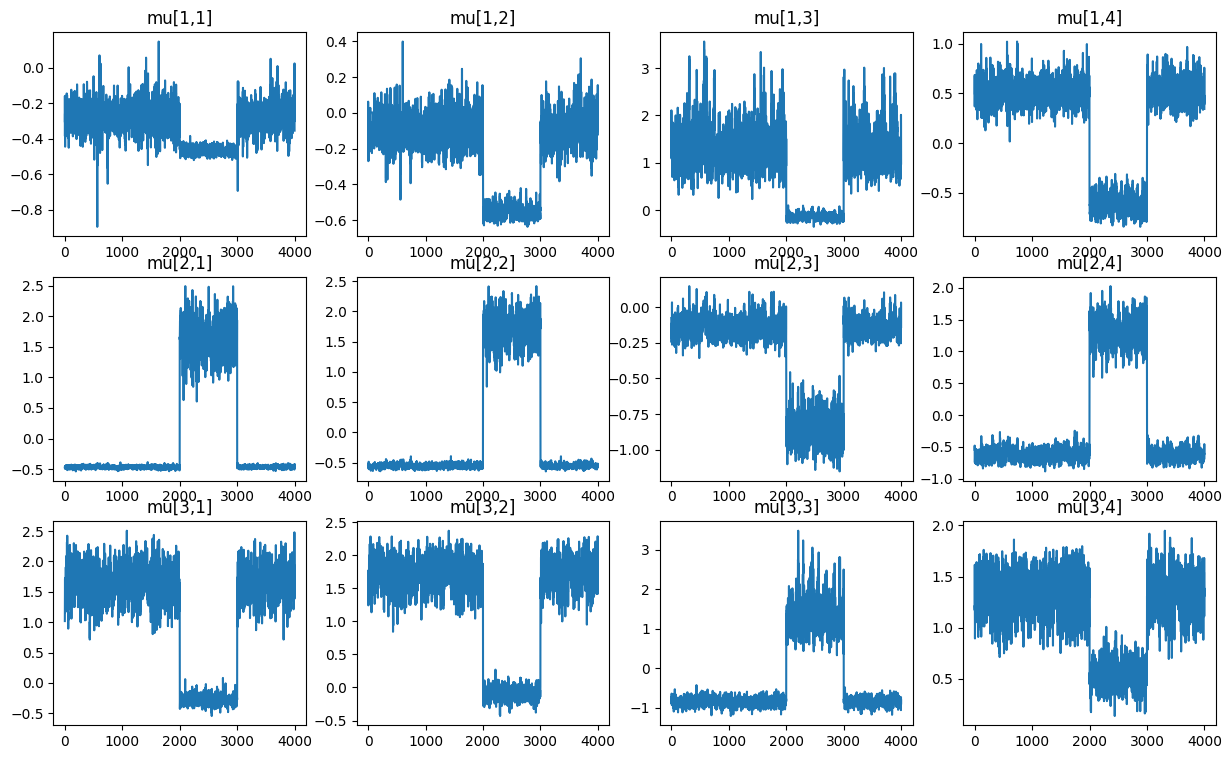

In [50]:
fig, axsm = plt.subplots(3, 4, figsize=(15,9))

axsm[0,0].plot(fitfg.draws_pd()['mu[1,1]'])
axsm[0,0].set_title('mu[1,1]')

axsm[0,1].plot(fitfg.draws_pd()['mu[1,2]'])
axsm[0,1].set_title('mu[1,2]')

axsm[0,2].plot(fitfg.draws_pd()['mu[1,3]'])
axsm[0,2].set_title('mu[1,3]')

axsm[0,3].plot(fitfg.draws_pd()['mu[1,4]'])
axsm[0,3].set_title('mu[1,4]')

axsm[1,0].plot(fitfg.draws_pd()['mu[2,1]'])
axsm[1,0].set_title('mu[2,1]')

axsm[1,1].plot(fitfg.draws_pd()['mu[2,2]'])
axsm[1,1].set_title('mu[2,2]')

axsm[1,2].plot(fitfg.draws_pd()['mu[2,3]'])
axsm[1,2].set_title('mu[2,3]')

axsm[1,3].plot(fitfg.draws_pd()['mu[2,4]'])
axsm[1,3].set_title('mu[2,4]')

axsm[2,0].plot(fitfg.draws_pd()['mu[3,1]'])
axsm[2,0].set_title('mu[3,1]')

axsm[2,1].plot(fitfg.draws_pd()['mu[3,2]'])
axsm[2,1].set_title('mu[3,2]')

axsm[2,2].plot(fitfg.draws_pd()['mu[3,3]'])
axsm[2,2].set_title('mu[3,3]')

axsm[2,3].plot(fitfg.draws_pd()['mu[3,4]'])
axsm[2,3].set_title('mu[3,4]')

These are as expected: fuzzy but with jumps. Some more egregious than others, but nothing awful.

He mentioned trying to visualize to see how many groups there need to be. Here is the visualization. This one seems to indicate that there shoud only be 2 clusters. I had this on a model earlier which was much cleaner and clearly identified 3 columns. To reiterate, I understand there may be use cases to boiling down to 2 clusters(probably diabetes and not) or potentially 4. But for this assignment for checking my accuracy I stuck with the 3 clusters. This is interesting though.

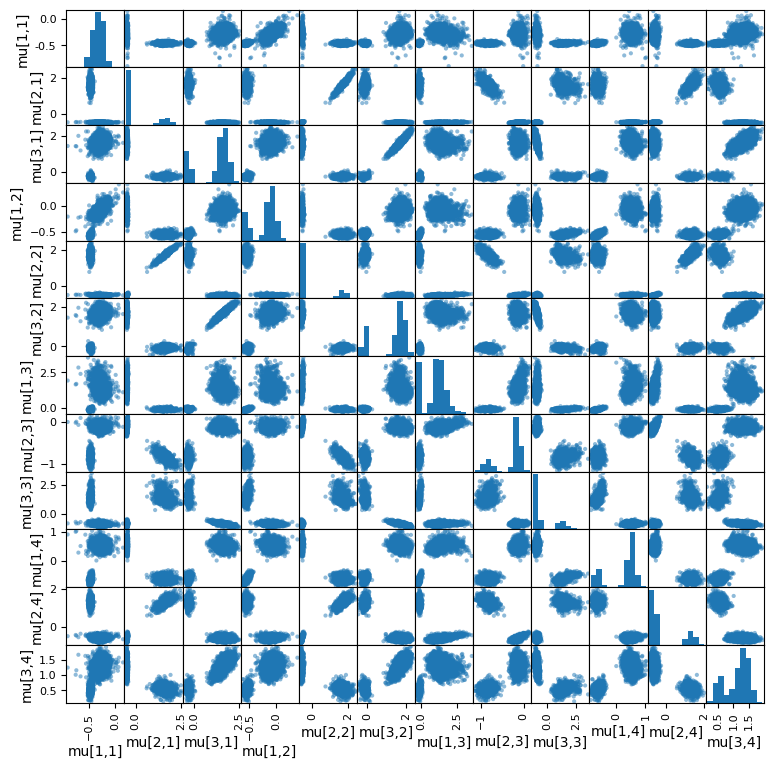

In [51]:
pd.plotting.scatter_matrix(mu_samples, figsize=(9,9))
plt.show()

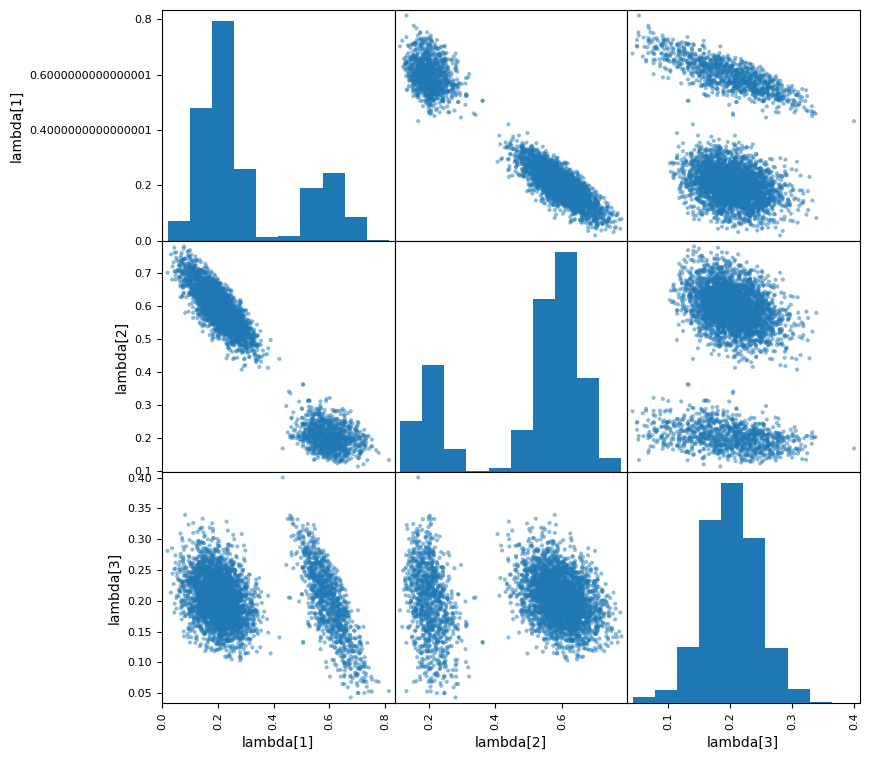

In [53]:
lambda_samples = posterior_df[['lambda[1]', 'lambda[2]', 'lambda[3]']]
pd.plotting.scatter_matrix(lambda_samples, figsize=(9,9))
plt.show()

There was a question about if we can trust $\hat{R}$s from the label_probs. Here is a printout of 50 label_prob $\hat{R}$s. There are 3 $\hat{R}$s for each label_prob: one for each lamda. For the most part each group of 3 have two high $\hat{R}$s and one that is close to 1. However there are some (like label_prob[26]) in which all 3 are close to 1. I suspect that in the former case, this would represent an accurately labelled point and the latter is perhaps an incorrectly labelled point (perhaps because it's less of a coin flip). So whould we trust them? not individually. but taken as groups can give insight into how the algorithm classified each point, or had trouble doing so.

In [57]:
fitfg.summary().iloc[100:150]

Mean      MCSE    StdDev            5%           50%  \
label_prob[13,1]  0.250420  0.304012  0.430626  2.962150e-08  6.351480e-04   
label_prob[13,2]  0.747722  0.304099  0.430742  1.815780e-05  9.971570e-01   
label_prob[13,3]  0.001858  0.000134  0.005478  2.762060e-07  2.759100e-04   
label_prob[14,1]  0.250056  0.305520  0.432721  2.532520e-09  8.821420e-05   
label_prob[14,2]  0.749683  0.305518  0.432718  1.364500e-06  9.996140e-01   
label_prob[14,3]  0.000261  0.000019  0.000708  1.551640e-08  3.138150e-05   
label_prob[15,1]  0.249978  0.305645  0.432898  2.427520e-11  8.397650e-06   
label_prob[15,2]  0.749846  0.305611  0.432849  2.623440e-07  9.998570e-01   
label_prob[15,3]  0.000175  0.000015  0.000630  5.209540e-10  7.382150e-06   
label_prob[16,1]  0.250143  0.304857  0.431788  3.251450e-08  3.738690e-04   
label_prob[16,2]  0.748730  0.304741  0.431626  1.033010e-05  9.982480e-01   
label_prob[16,3]  0.001126  0.000075  0.002546  1.853860e-07  1.838720e-04   
label_prob[17,1]  0.249952  0.305611  0.432849  1.964050e-11  1.402230e-05   
label_prob[17,2]  0.749803  0.305542  0.432752  1.591480e-06  9.997390e-01   
label_prob[17,3]  0.000245  0.000031  0.000610  2.093820e-09  2.016520e-05   
label_prob[18,1]  0.249947  0.305638  0.432888  2.298000e-13  2.248750e-06   
label_prob[18,2]  0.749847  0.305586  0.432815  2.361710e-07  9.998870e-01   
label_prob[18,3]  0.000205  0.000020  0.000786  4.200150e-11  5.116570e-06   
label_prob[19,1]  0.249958  0.305682  0.432950  6.200000e-14  1.098020e-06   
label_prob[19,2]  0.749907  0.305640  0.432890  2.584690e-07  9.999150e-01   
label_prob[19,3]  0.000136  0.000018  0.000420  2.623960e-11  4.552690e-06   
label_prob[20,1]  0.249947  0.305666  0.432927  5.160000e-14  1.438200e-06   
label_prob[20,2]  0.749889  0.305612  0.432851  4.313690e-07  9.998820e-01   
label_prob[20,3]  0.000164  0.000034  0.000477  4.740230e-11  6.415100e-06   
label_prob[21,1]  0.249897  0.305578  0.432802  1.824000e-13  3.261740e-06   
label_prob[21,2]  0.749778  0.305467  0.432646  1.301060e-06  9.997470e-01   
label_prob[21,3]  0.000325  0.000075  0.000907  1.517800e-10  1.541460e-05   
label_prob[22,1]  0.249958  0.305694  0.432966  2.480000e-14  5.937420e-07   
label_prob[22,2]  0.749919  0.305652  0.432907  2.010210e-07  9.999320e-01   
label_prob[22,3]  0.000123  0.000024  0.000400  1.547040e-11  3.250690e-06   
label_prob[23,1]  0.250009  0.305622  0.432864  3.788810e-10  3.400890e-05   
label_prob[23,2]  0.749822  0.305605  0.432841  6.953770e-07  9.997740e-01   
label_prob[23,3]  0.000169  0.000012  0.000471  4.615220e-09  1.746100e-05   
label_prob[24,1]  0.250141  0.305411  0.432567  2.385850e-08  1.939640e-04   
label_prob[24,2]  0.749553  0.305454  0.432627  2.082020e-06  9.994340e-01   
label_prob[24,3]  0.000305  0.000023  0.000782  4.922430e-08  4.701400e-05   
label_prob[25,1]  0.251284  0.303041  0.429583  4.558160e-08  9.519260e-04   
label_prob[25,2]  0.747225  0.304559  0.431462  1.315610e-08  9.987860e-01   
label_prob[25,3]  0.001492  0.001181  0.017675  1.931560e-10  5.641820e-06   
label_prob[26,1]  0.402954  0.109885  0.322303  9.623310e-03  3.354810e-01   
label_prob[26,2]  0.499262  0.199623  0.369567  1.249110e-03  5.451520e-01   
label_prob[26,3]  0.097783  0.089237  0.192053  2.238600e-04  1.702540e-02   
label_prob[27,1]  0.251576  0.303385  0.429741  7.013060e-07  2.425570e-03   
label_prob[27,2]  0.746902  0.304113  0.430763  2.121160e-05  9.962450e-01   
label_prob[27,3]  0.001522  0.000591  0.003764  1.219230e-06  3.330540e-04   
label_prob[28,1]  0.250467  0.304942  0.431907  1.509950e-07  6.907930e-04   
label_prob[28,2]  0.748950  0.305139  0.432185  5.495970e-06  9.986500e-01   
label_prob[28,3]  0.000583  0.000110  0.001456  2.065970e-07  1.099850e-04   
label_prob[29,1]  0.250441  0.304820  0.431737  1.929320e-07  6.765770e-04   
label_prob[29,2]  0.748791  0.304984  0.431968  9.524570e-06  9.983420e-01   

                       95%       N_Eff    N

The last question was about if there were any scientific questions left out in the model. To that I'll be honest and say I don't know. One question I do have: When I looked this dataset up online I noticed it said that the measurement were on "145 non-obese adult patients". Why did they only use non-obese adult patients? What happened to the obese ones? What about adolescent patients? how do those change our data and does that data make it easier to classify? (a side note: While I'm sure still relavant gives some clarity as to why 'relwt' never gave us much information. I get that non-obese can be a big umbrella, but I feel the left a category, a big one in terms of diabetes (pun intended?))

Thanks for reading through this. I hope reading all of this is less painful than going through it :)